# NFL Big Data Bowl 2026 - Full Analysis

This notebook:
1. Loads ALL weeks of data (input + output)
2. Combines with supplementary data
3. Calculates Defensive Convergence Speed metric
4. Aggregates by player, position, team
5. Identifies patterns and standout performers

**Metric**: Defensive Convergence Speed - How fast defenders close on ball landing spot

## Setup and Imports

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✅ Imports successful!")

✅ Imports successful!


## 1. Load ALL Weeks of Data

This will load and combine all input and output files from weeks 2-18.

In [71]:
# Define paths
DATA_DIR = Path('../data')
COMPETITION_DIR = DATA_DIR / '114239_nfl_competition_files_published_analytics_final'
TRAIN_DIR = COMPETITION_DIR / 'train'

print("📂 Scanning for data files...")
print("="*80)

# Find all input and output files
input_files = sorted(TRAIN_DIR.glob('input_2023_w*.csv'))
output_files = sorted(TRAIN_DIR.glob('output_2023_w*.csv'))

print(f"Found {len(input_files)} input files (weeks)")
print(f"Found {len(output_files)} output files (weeks)")
print(f"\nInput files: {[f.stem for f in input_files]}")
print(f"\nOutput files: {[f.stem for f in output_files]}")

📂 Scanning for data files...
Found 18 input files (weeks)
Found 18 output files (weeks)

Input files: ['input_2023_w01', 'input_2023_w02', 'input_2023_w03', 'input_2023_w04', 'input_2023_w05', 'input_2023_w06', 'input_2023_w07', 'input_2023_w08', 'input_2023_w09', 'input_2023_w10', 'input_2023_w11', 'input_2023_w12', 'input_2023_w13', 'input_2023_w14', 'input_2023_w15', 'input_2023_w16', 'input_2023_w17', 'input_2023_w18']

Output files: ['output_2023_w01', 'output_2023_w02', 'output_2023_w03', 'output_2023_w04', 'output_2023_w05', 'output_2023_w06', 'output_2023_w07', 'output_2023_w08', 'output_2023_w09', 'output_2023_w10', 'output_2023_w11', 'output_2023_w12', 'output_2023_w13', 'output_2023_w14', 'output_2023_w15', 'output_2023_w16', 'output_2023_w17', 'output_2023_w18']


In [72]:
def load_all_weeks(file_list, file_type="input"):
    """
    Load and combine all weekly files
    """
    print(f"\n📥 Loading all {file_type} files...")
    
    all_data = []
    
    for file_path in tqdm(file_list, desc=f"Loading {file_type} weeks"):
        try:
            df = pd.read_csv(file_path)
            
            # Extract week number from filename
            week_num = int(file_path.stem.split('_w')[1])
            df['week'] = week_num
            
            all_data.append(df)
            
        except Exception as e:
            print(f"\n⚠️  Error loading {file_path.name}: {e}")
    
    # Combine all weeks
    combined_df = pd.concat(all_data, ignore_index=True)
    
    print(f"\n✅ Loaded {len(combined_df):,} total rows from {len(all_data)} weeks")
    print(f"   Memory usage: {combined_df.memory_usage(deep=True).sum() / (1024**2):.1f} MB")
    
    return combined_df

# Load all input data (frame 1 - moment of throw)
all_input = load_all_weeks(input_files, "input")

# Load all output data (frames 2+ - after throw)
all_output = load_all_weeks(output_files, "output")


📥 Loading all input files...


Loading input weeks: 100%|██████████| 18/18 [00:10<00:00,  1.74it/s]



✅ Loaded 4,880,579 total rows from 18 weeks
   Memory usage: 2461.6 MB

📥 Loading all output files...


Loading output weeks: 100%|██████████| 18/18 [00:00<00:00, 34.09it/s]


✅ Loaded 562,936 total rows from 18 weeks
   Memory usage: 30.1 MB


In [73]:
# Quick summary
print("\n" + "="*80)
print("COMBINED DATA SUMMARY")
print("="*80)

print(f"\nINPUT DATA:")
print(f"  Shape: {all_input.shape}")
print(f"  Weeks: {sorted(all_input['week'].unique())}")
print(f"  Unique plays: {all_input.groupby(['game_id', 'play_id']).ngroups:,}")
print(f"  Unique players: {all_input['nfl_id'].nunique():,}")

print(f"\nOUTPUT DATA:")
print(f"  Shape: {all_output.shape}")
print(f"  Weeks: {sorted(all_output['week'].unique())}")
print(f"  Unique plays: {all_output.groupby(['game_id', 'play_id']).ngroups:,}")
print(f"  Frame range: {all_output['frame_id'].min()} to {all_output['frame_id'].max()}")


COMBINED DATA SUMMARY

INPUT DATA:
  Shape: (4880579, 24)
  Weeks: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18)]
  Unique plays: 14,108
  Unique players: 1,384

OUTPUT DATA:
  Shape: (562936, 7)
  Weeks: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18)]
  Unique plays: 14,108
  Frame range: 1 to 94


## 2. Load and Merge Supplementary Data

The supplementary data contains additional play/player context.

In [74]:
# Load supplementary data
print("Loading supplementary data...")
supp_data = pd.read_csv(COMPETITION_DIR / 'supplementary_data.csv')

print(f"✅ Loaded: {len(supp_data):,} rows")
print(f"\nColumns in supplementary data:")
for col in supp_data.columns:
    print(f"  • {col}")

Loading supplementary data...
✅ Loaded: 18,009 rows

Columns in supplementary data:
  • game_id
  • season
  • week
  • game_date
  • game_time_eastern
  • home_team_abbr
  • visitor_team_abbr
  • play_id
  • play_description
  • quarter
  • game_clock
  • down
  • yards_to_go
  • possession_team
  • defensive_team
  • yardline_side
  • yardline_number
  • pre_snap_home_score
  • pre_snap_visitor_score
  • play_nullified_by_penalty
  • pass_result
  • pass_length
  • offense_formation
  • receiver_alignment
  • route_of_targeted_receiver
  • play_action
  • dropback_type
  • dropback_distance
  • pass_location_type
  • defenders_in_the_box
  • team_coverage_man_zone
  • team_coverage_type
  • penalty_yards
  • pre_penalty_yards_gained
  • yards_gained
  • expected_points
  • expected_points_added
  • pre_snap_home_team_win_probability
  • pre_snap_visitor_team_win_probability
  • home_team_win_probability_added
  • visitor_team_win_probility_added


In [75]:
# Preview supplementary data
print("\nSupplementary data preview:")
print("="*80)
supp_data.head()


Supplementary data preview:


,game_id,season,week,game_date,game_time_eastern,home_team_abbr,visitor_team_abbr,play_id,play_description,quarter,game_clock,down,yards_to_go,possession_team,defensive_team,yardline_side,yardline_number,pre_snap_home_score,pre_snap_visitor_score,play_nullified_by_penalty,pass_result,pass_length,offense_formation,receiver_alignment,route_of_targeted_receiver,play_action,dropback_type,dropback_distance,pass_location_type,defenders_in_the_box,team_coverage_man_zone,team_coverage_type,penalty_yards,pre_penalty_yards_gained,yards_gained,expected_points,expected_points_added,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,home_team_win_probability_added,visitor_team_win_probility_added
0,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,3461,(10:46) (Shotgun) J.Goff pass deep left to J.R...,4,10:46,3,12,DET,KC,DET,23,20,14,N,C,18,EMPTY,3x2,IN,False,TRADITIONAL,5.30,INSIDE_BOX,6,ZONE_COVERAGE,COVER_2_ZONE,NaN,18,18,-0.664416,2.945847,0.834296,0.165704,-0.081149,0.081149
1,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,461,(7:30) J.Goff pass short right to J.Reynolds t...,1,07:30,1,10,DET,KC,DET,34,0,0,N,C,13,SINGLEBACK,3x1,POST,True,TRADITIONAL,4.72,INSIDE_BOX,7,ZONE_COVERAGE,COVER_6_ZONE,NaN,21,21,1.926131,1.345633,0.544618,0.455382,-0.029415,0.029415
2,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1940,(:09) (Shotgun) J.Goff pass incomplete deep ri...,2,00:09,2,10,DET,KC,DET,42,14,7,N,I,18,SHOTGUN,3x1,OUT,False,TRADITIONAL,4.44,INSIDE_BOX,6,ZONE_COVERAGE,COVER_2_ZONE,NaN,0,0,0.281891,-0.081964,0.771994,0.228006,0.000791,-0.000791
3,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1711,"(:45) (No Huddle, Shotgun) P.Mahomes pass deep...",2,00:45,1,10,KC,DET,DET,30,7,7,N,C,23,SHOTGUN,3x1,CORNER,False,TRADITIONAL,5.36,INSIDE_BOX,5,ZONE_COVERAGE,COVER_2_ZONE,NaN,26,26,3.452352,2.342947,0.663187,0.336813,0.041843,-0.041843
4,2023090700,2023,1,09/07/2023,20:20:00,KC,DET,1588,(1:54) (Shotgun) P.Mahomes pass incomplete dee...,2,01:54,1,10,KC,DET,KC,43,7,7,N,I,38,SHOTGUN,2x2,POST,False,TRADITIONAL,4.59,INSIDE_BOX,6,ZONE_COVERAGE,COVER_4_ZONE,NaN,0,0,1.921525,-0.324035,0.615035,0.384965,0.000061,-0.000061


In [76]:
# Check what type of information is in supplementary data
print("Supplementary data content check:")
print("="*80)
print(f"Shape: {supp_data.shape}")
print(f"\nSample of unique values:")
for col in supp_data.columns[:10]:  # First 10 columns
    n_unique = supp_data[col].nunique()
    print(f"  {col}: {n_unique} unique values")

Supplementary data content check:
Shape: (18009, 41)

Sample of unique values:
  game_id: 349 unique values
  season: 2 unique values
  week: 18 unique values
  game_date: 73 unique values
  game_time_eastern: 13 unique values
  home_team_abbr: 32 unique values
  visitor_team_abbr: 32 unique values
  play_id: 4471 unique values
  play_description: 18005 unique values
  quarter: 5 unique values


## 3. Data Cleaning and Preparation

In [77]:
# Check for missing values
print("Missing values in INPUT data:")
print("="*80)
missing_input = all_input.isnull().sum()
missing_input = missing_input[missing_input > 0].sort_values(ascending=False)
if len(missing_input) > 0:
    print(missing_input)
else:
    print("✅ No missing values!")

print("\nMissing values in OUTPUT data:")
print("="*80)
missing_output = all_output.isnull().sum()
missing_output = missing_output[missing_output > 0].sort_values(ascending=False)
if len(missing_output) > 0:
    print(missing_output)
else:
    print("✅ No missing values!")

Missing values in INPUT data:
✅ No missing values!

Missing values in OUTPUT data:
✅ No missing values!


In [78]:
# Remove any rows with missing critical data
print("\nCleaning data...")
original_input_len = len(all_input)
original_output_len = len(all_output)

# Remove rows where we don't have position data
all_input = all_input.dropna(subset=['x', 'y', 'ball_land_x', 'ball_land_y'])
all_output = all_output.dropna(subset=['x', 'y'])

print(f"Input data: Removed {original_input_len - len(all_input):,} rows with missing data")
print(f"Output data: Removed {original_output_len - len(all_output):,} rows with missing data")
print(f"\n✅ Clean data ready for analysis!")


Cleaning data...
Input data: Removed 0 rows with missing data
Output data: Removed 0 rows with missing data

✅ Clean data ready for analysis!


## 4. Build Core Metric: All Player Convergence Speed

Calculate how fast All Players ('Defensive Coverage', 'Other Route Runner','Passer', 'Targeted Receiver') close distance to ball landing spot.

In [79]:
def calculate_convergence_speed_for_play(game_id, play_id, input_df, output_df, 
                                        player_roles=['Defensive Coverage', 'Other Route Runner', 
                                                     'Passer', 'Targeted Receiver']):
    """
    Calculate convergence speed for multiple player roles in a single play
    
    Args:
        game_id: Game identifier
        play_id: Play identifier
        input_df: Input dataframe (frame 1)
        output_df: Output dataframe (frames 2+)
        player_roles: List of player roles to analyze
    
    Returns:
        DataFrame with convergence metrics for each player across all specified roles
    """
    # Get play data
    play_input = input_df[(input_df['game_id'] == game_id) & (input_df['play_id'] == play_id)]
    play_output = output_df[(output_df['game_id'] == game_id) & (output_df['play_id'] == play_id)]
    
    if len(play_input) == 0 or len(play_output) == 0:
        return None
    
    # Get ball landing location and week
    ball_land_x = play_input['ball_land_x'].iloc[0]
    ball_land_y = play_input['ball_land_y'].iloc[0]
    week = play_input['week'].iloc[0]
    
    # Combine input and output
    play_complete = pd.concat([play_input, play_output], ignore_index=True)
    
    # Get ALL players with specified roles (instead of just first one)
    players = play_complete[play_complete['player_role'].isin(player_roles)].copy()
    
    if len(players) == 0:
        return None
    
    # Calculate distance to landing spot for each frame
    players['dist_to_landing'] = np.sqrt(
        (players['x'] - ball_land_x)**2 + 
        (players['y'] - ball_land_y)**2
    )
    
    # Calculate convergence metrics for each player
    results = []
    
    for player_id in players['nfl_id'].unique():
        player_data = players[players['nfl_id'] == player_id].sort_values('frame_id')
        
        if len(player_data) > 1:
            # Basic metrics
            initial_dist = player_data['dist_to_landing'].iloc[0]
            final_dist = player_data['dist_to_landing'].iloc[-1]
            min_dist = player_data['dist_to_landing'].min()
            num_frames = len(player_data)
            time_elapsed = num_frames / 10  # Convert frames to seconds
            
            # Convergence speed (positive = moving closer)
            convergence_speed = (initial_dist - final_dist) / time_elapsed
            
            # Average speed during play
            avg_speed = player_data['s'].mean()
            max_speed = player_data['s'].max()
            
            # Did they get closer or farther?
            distance_change = final_dist - initial_dist
            
            # Get player role (most common if it changes, which shouldn't happen)
            player_role = player_data['player_role'].mode()[0] if len(player_data) > 0 else None
            
            results.append({
                'week': week,
                'game_id': game_id,
                'play_id': play_id,
                'nfl_id': player_id,
                'player_role': player_role,  # ✅ Added player_role to output
                'player_position': player_data['player_position'].iloc[0],
                'initial_distance': initial_dist,
                'final_distance': final_dist,
                'min_distance': min_dist,
                'distance_change': distance_change,
                'time_elapsed': time_elapsed,
                'convergence_speed': convergence_speed,
                'avg_speed': avg_speed,
                'max_speed': max_speed,
                'num_frames': num_frames
            })
    
    return pd.DataFrame(results)

print("✅ Enhanced convergence speed function defined (handles multiple player roles)")

✅ Enhanced convergence speed function defined (handles multiple player roles)


In [80]:
# Test on a single play first
print("Testing on first play...")
test_game = all_input['game_id'].iloc[0]
test_play = all_input['play_id'].iloc[0]

test_result = calculate_convergence_speed_for_play(test_game, test_play, all_input, all_output)

if test_result is not None:
    print("\n✅ Test successful!")
    print("\nSample output:")
    print(test_result[['nfl_id', 'player_role', 'player_position', 'convergence_speed', 'initial_distance', 'final_distance']].round(2))
    print(f"\nPlayer roles found: {test_result['player_role'].unique()}")
else:
    print("\n⚠️  No players with specified roles in this play")

Testing on first play...

✅ Test successful!

Sample output:
   nfl_id         player_role player_position  convergence_speed  \
0   54527  Defensive Coverage              FS               0.93   
1   46137  Defensive Coverage              SS               1.81   
2   52546  Defensive Coverage              CB               0.95   
3   53487  Defensive Coverage             MLB               2.79   
4   54486  Defensive Coverage              CB              -0.04   
5   53541  Other Route Runner              WR               3.28   
6   53959  Other Route Runner              TE               1.18   
7   43290              Passer              QB              -0.48   
8   44930   Targeted Receiver              WR               2.87   

   initial_distance  final_distance  
0             38.73           36.31  
1             24.08           19.38  
2             22.29           19.82  
3             33.57           26.31  
4             44.24           44.34  
5             29.78           

## 5. Calculate Metric for ALL Plays

**Warning**: This may take 5 - 10 minutes depending on data size and node.

In [81]:
# Get all unique plays
unique_plays = all_input[['week', 'game_id', 'play_id']].drop_duplicates()

print(f"Total plays to analyze: {len(unique_plays):,}")
print(f"\nThis will take approximately {len(unique_plays) / 1000:.1f} minutes...")
print("\n⏳ Start the calculation...\n")

Total plays to analyze: 14,108

This will take approximately 14.1 minutes...

⏳ Start the calculation...



In [82]:
# Calculate for all plays
all_convergence_results = []

for idx, row in tqdm(unique_plays.iterrows(), total=len(unique_plays), desc="Processing plays"):
    result = calculate_convergence_speed_for_play(
        row['game_id'], 
        row['play_id'], 
        all_input, 
        all_output
    )
    
    if result is not None:
        all_convergence_results.append(result)

# Combine all results
convergence_df = pd.concat(all_convergence_results, ignore_index=True)

print(f"\n✅ Analysis complete!")
print(f"\nTotal player tracking instances: {len(convergence_df):,}")
print(f"Unique players: {convergence_df['nfl_id'].nunique():,}")
print(f"Unique plays analyzed: {convergence_df.groupby(['game_id', 'play_id']).ngroups:,}")
print(f"\nBreakdown by player role:")
print(convergence_df['player_role'].value_counts())

Processing plays: 100%|██████████| 14108/14108 [06:17<00:00, 37.37it/s]



✅ Analysis complete!

Total player tracking instances: 173,150
Unique players: 1,384
Unique plays analyzed: 14,108

Breakdown by player role:
player_role
Defensive Coverage    94293
Other Route Runner    50644
Targeted Receiver     14108
Passer                14105
Name: count, dtype: int64


In [83]:
# Save intermediate results
output_dir = Path('../data/processed')
output_dir.mkdir(exist_ok=True)


convergence_df.to_csv(output_dir / 'convergence_speed_all_plays.csv', index=False)
print(f"\n💾 Results saved to: {output_dir / 'convergence_speed_all_plays.csv'}")


💾 Results saved to: ..\data\processed\convergence_speed_all_plays.csv


## 6. Overall Statistics and Distribution

In [84]:
# Overall statistics
print("="*80)
print("All ROLES CONVERGENCE SPEED - OVERALL STATISTICS")
print("="*80)

print(f"\nConvergence Speed (yards/second):")
print(f"  Mean: {convergence_df['convergence_speed'].mean():.2f}")
print(f"  Median: {convergence_df['convergence_speed'].median():.2f}")
print(f"  Std Dev: {convergence_df['convergence_speed'].std():.2f}")
print(f"  Min: {convergence_df['convergence_speed'].min():.2f}")
print(f"  Max: {convergence_df['convergence_speed'].max():.2f}")

print(f"\nDistance Metrics (yards):")
print(f"  Avg Initial Distance: {convergence_df['initial_distance'].mean():.2f}")
print(f"  Avg Final Distance: {convergence_df['final_distance'].mean():.2f}")
print(f"  Avg Min Distance (closest approach): {convergence_df['min_distance'].mean():.2f}")

print(f"\nTime Metrics:")
print(f"  Avg Time Tracked: {convergence_df['time_elapsed'].mean():.2f} seconds")
print(f"  Avg Frames: {convergence_df['num_frames'].mean():.1f}")

All ROLES CONVERGENCE SPEED - OVERALL STATISTICS

Convergence Speed (yards/second):
  Mean: 0.09
  Median: -0.10
  Std Dev: 1.89
  Min: -7.74
  Max: 8.09

Distance Metrics (yards):
  Avg Initial Distance: 18.99
  Avg Final Distance: 18.70
  Avg Min Distance (closest approach): 16.46

Time Metrics:
  Avg Time Tracked: 2.82 seconds
  Avg Frames: 28.2


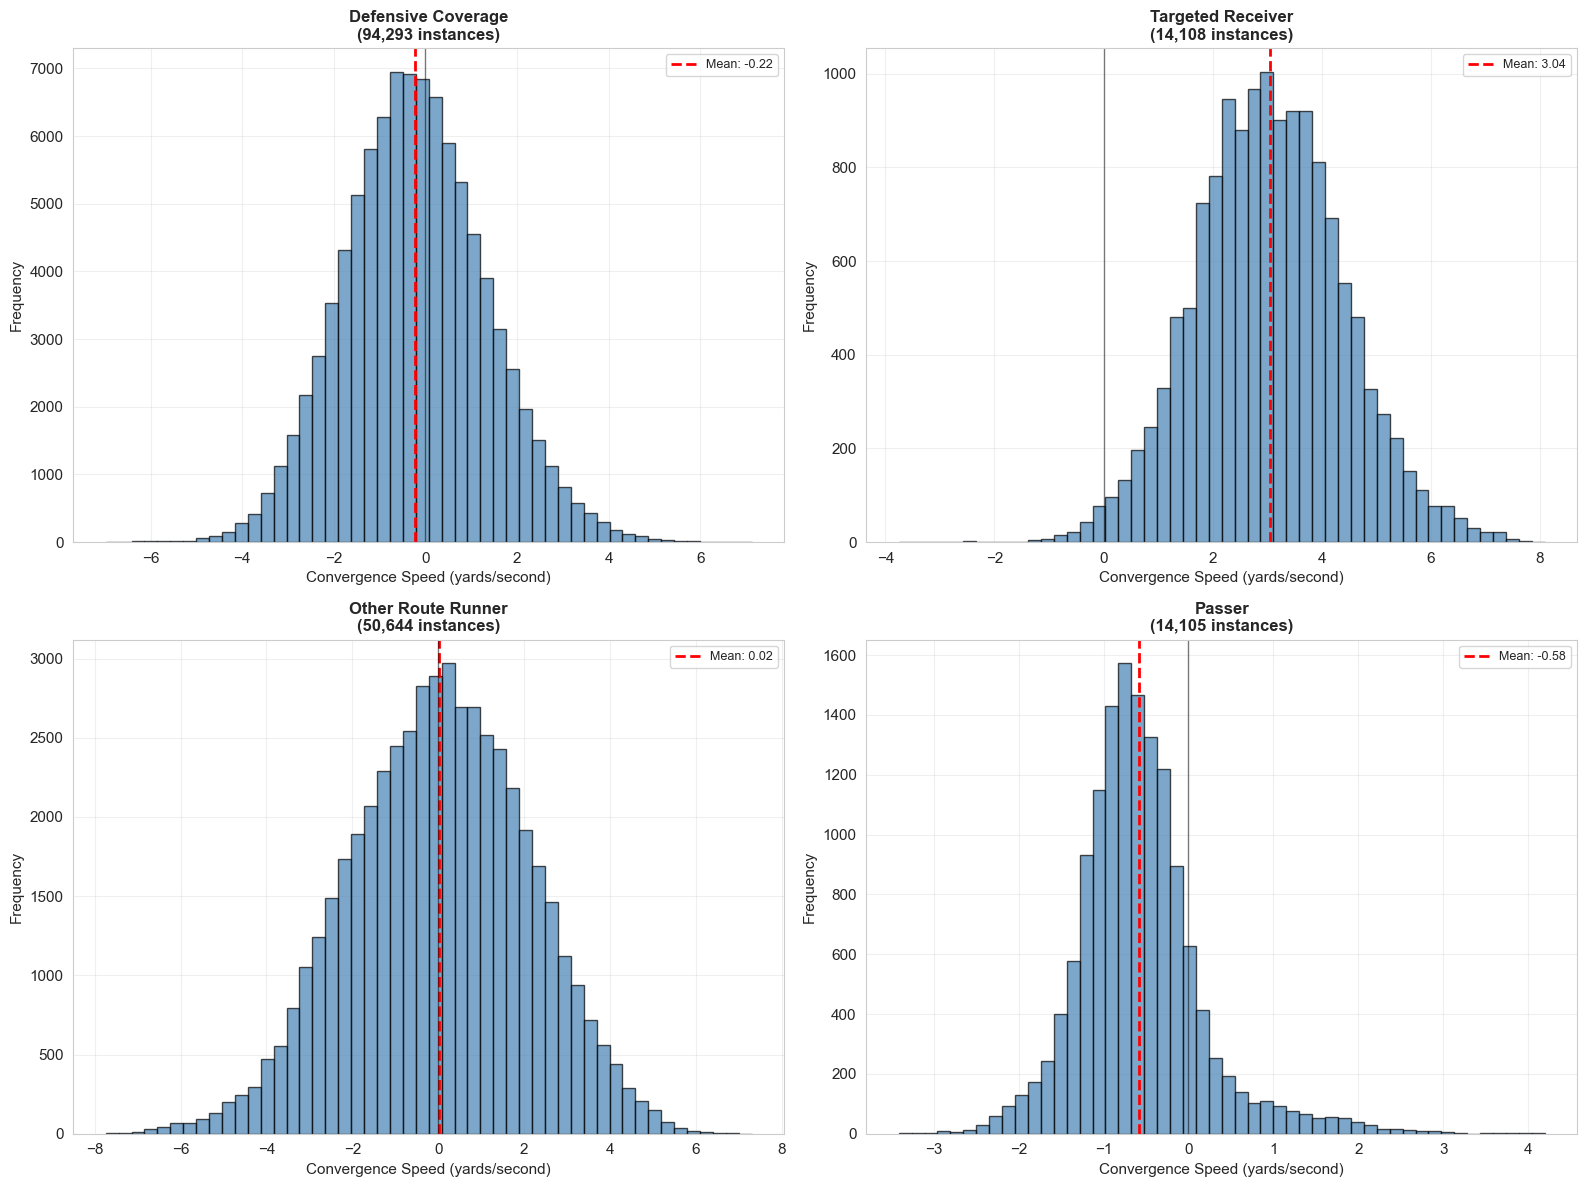


💾 Convergence speed distribution by role saved!


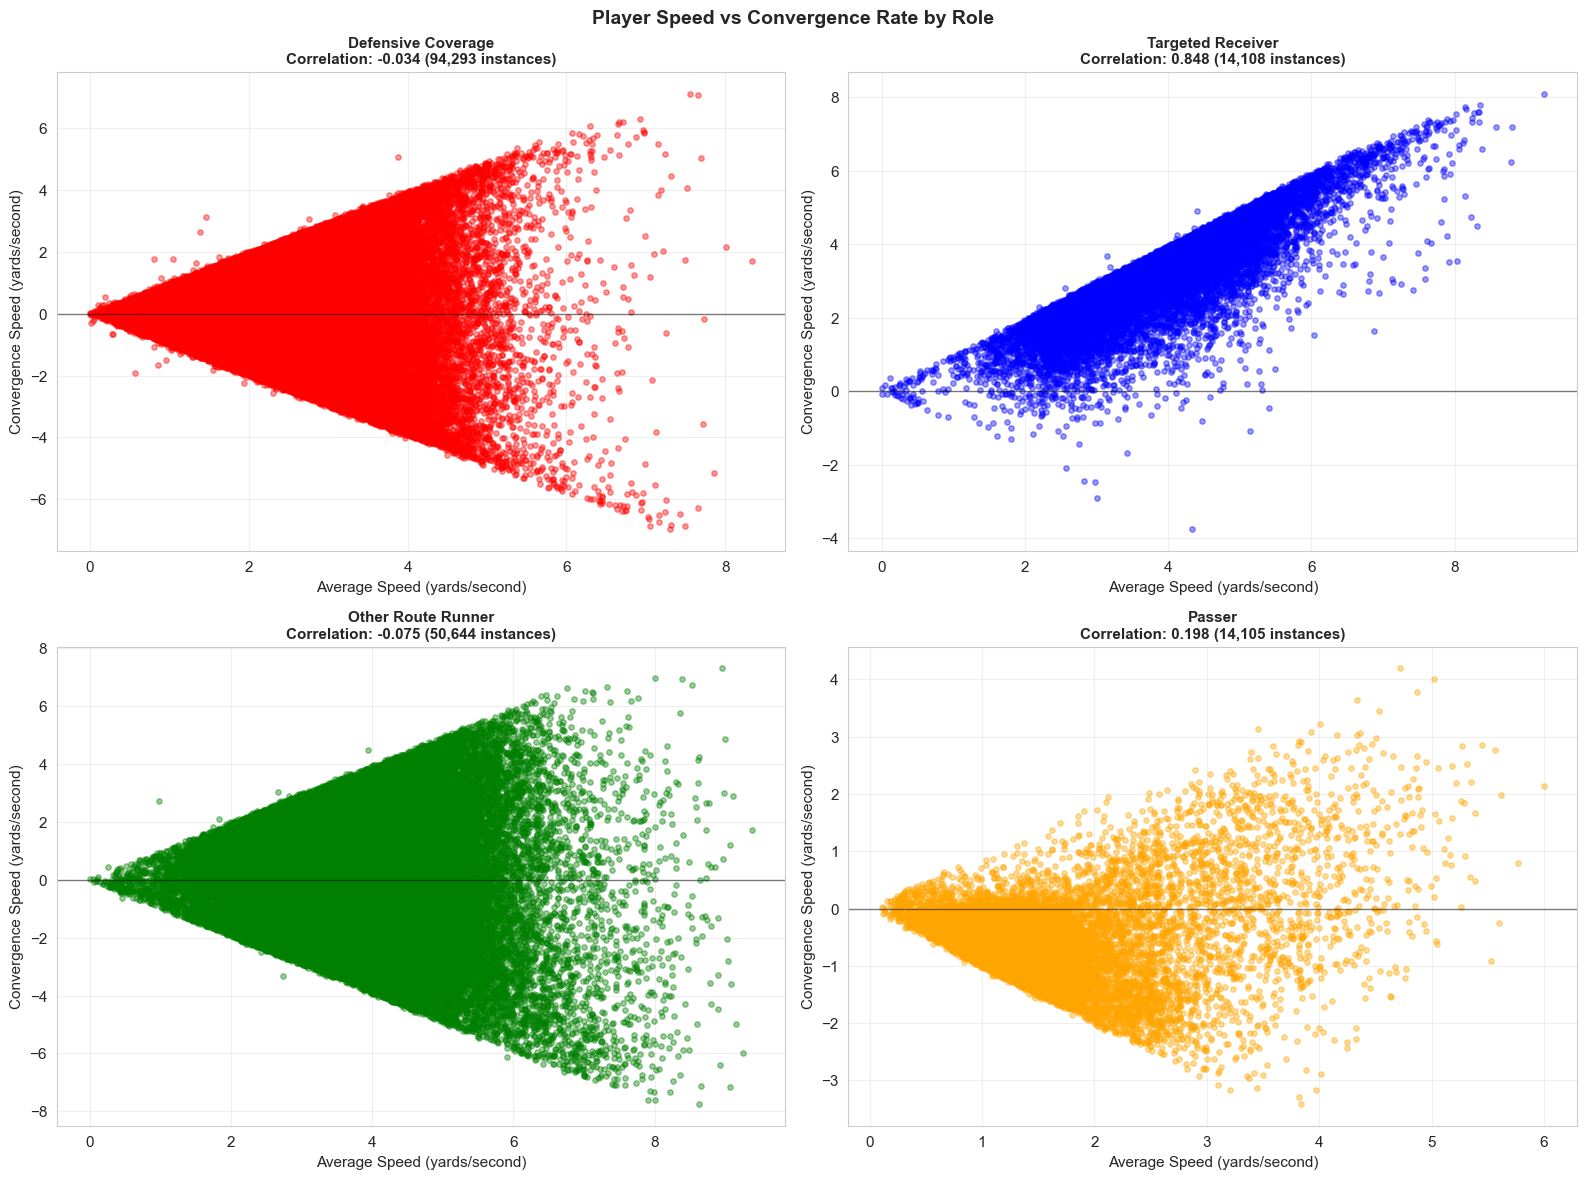


💾 Speed vs Convergence by role saved!


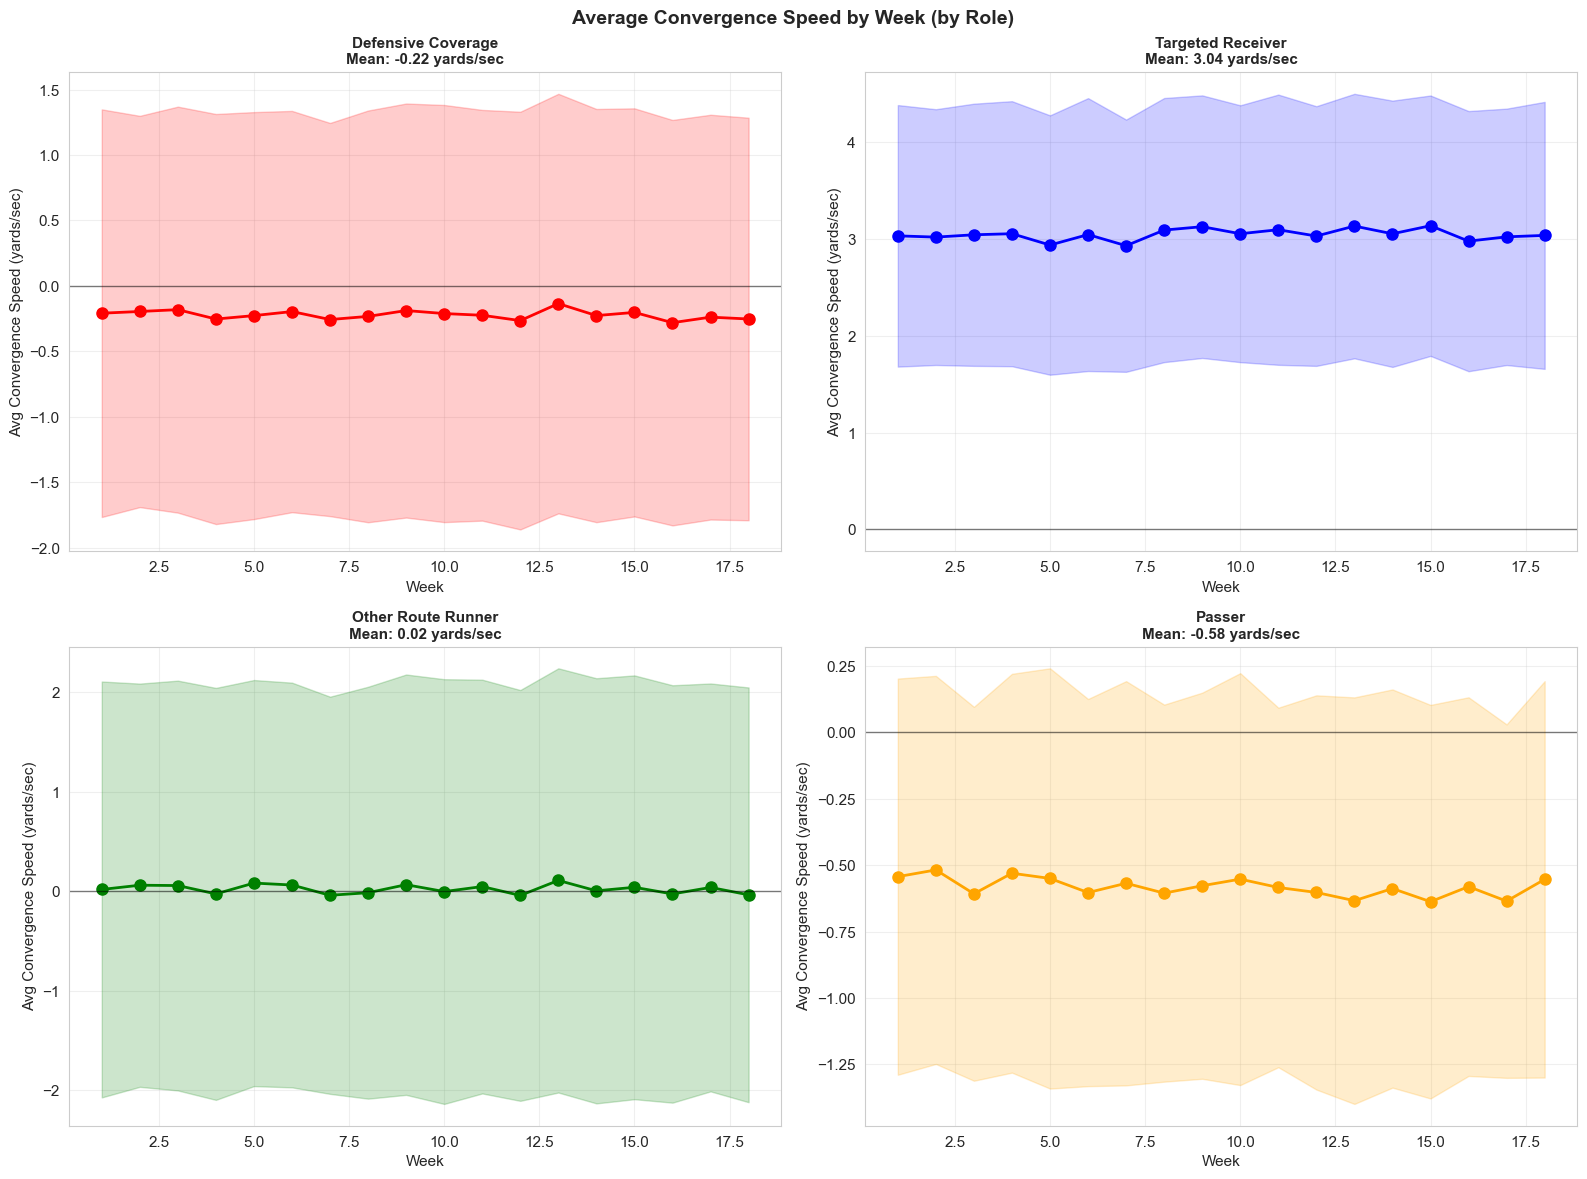


💾 Convergence by week (by role) saved!


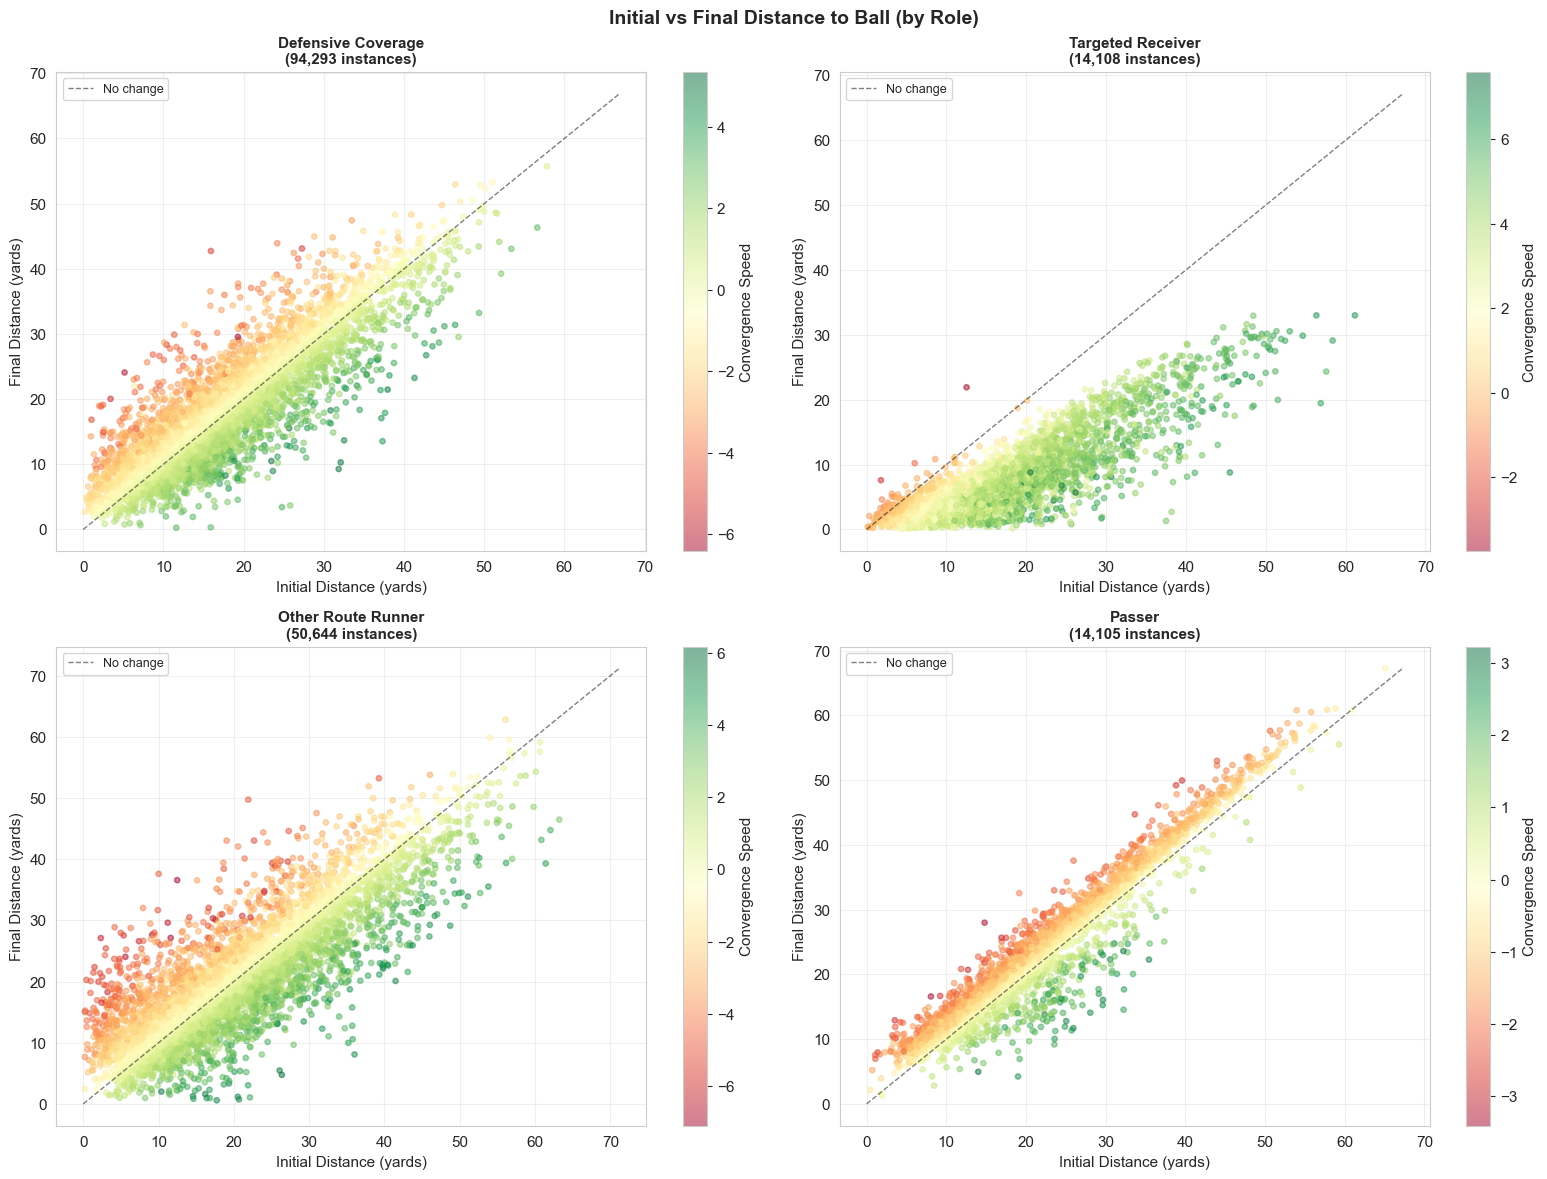


💾 Initial vs Final distance (by role) saved!

SUMMARY STATISTICS BY ROLE

                     Avg Conv Speed  Median Conv Speed  Std Conv Speed  Avg Player Speed  Avg Initial Dist  Avg Final Dist  Avg Min Dist  Count
player_role                                                                                                                                   
Defensive Coverage           -0.22              -0.26            1.56              2.40             18.14           18.70         16.42  94293
Other Route Runner            0.02               0.06            2.08              3.86             21.28           21.24         18.37  50644
Passer                       -0.58              -0.65            0.73              1.65             20.02           21.53         19.62  14105
Targeted Receiver             3.04               3.02            1.35              3.87             15.49            6.77          6.66  14108

💾 Summary statistics by role saved!


In [85]:
# Analyze each role separately
roles_to_analyze = ['Defensive Coverage', 'Targeted Receiver', 'Other Route Runner', 'Passer']

# 1. Convergence speed distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, role in enumerate(roles_to_analyze):
    role_data = convergence_df[convergence_df['player_role'] == role]
    
    if len(role_data) > 0:
        axes[idx].hist(role_data['convergence_speed'], bins=50, 
                      color='steelblue', edgecolor='black', alpha=0.7)
        axes[idx].axvline(role_data['convergence_speed'].mean(), color='red', 
                         linestyle='--', linewidth=2, 
                         label=f"Mean: {role_data['convergence_speed'].mean():.2f}")
        axes[idx].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        axes[idx].set_xlabel('Convergence Speed (yards/second)', fontsize=11)
        axes[idx].set_ylabel('Frequency', fontsize=11)
        axes[idx].set_title(f'{role}\n({len(role_data):,} instances)', 
                           fontsize=12, fontweight='bold')
        axes[idx].legend(fontsize=9)
        axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'convergence_by_role_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Convergence speed distribution by role saved!")

# Define roles and colors for consistency
role_colors = {'Defensive Coverage': 'red', 'Targeted Receiver': 'blue', 
               'Other Route Runner': 'green', 'Passer': 'orange'}

# 2. PLAYER SPEED VS CONVERGENCE RATE (by role)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, role in enumerate(roles_to_analyze):
    role_data = convergence_df[convergence_df['player_role'] == role]
    
    if len(role_data) > 0:
        axes[idx].scatter(role_data['avg_speed'], role_data['convergence_speed'], 
                         alpha=0.4, s=15, c=role_colors[role])
        axes[idx].axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        
        # Add correlation
        correlation = role_data['avg_speed'].corr(role_data['convergence_speed'])
        
        axes[idx].set_xlabel('Average Speed (yards/second)', fontsize=11)
        axes[idx].set_ylabel('Convergence Speed (yards/second)', fontsize=11)
        axes[idx].set_title(f'{role}\nCorrelation: {correlation:.3f} ({len(role_data):,} instances)', 
                           fontsize=11, fontweight='bold')
        axes[idx].grid(alpha=0.3)

plt.suptitle('Player Speed vs Convergence Rate by Role', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(output_dir / 'speed_vs_convergence_by_role.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Speed vs Convergence by role saved!")

# 3. AVERAGE CONVERGENCE SPEED BY WEEK (by role)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, role in enumerate(roles_to_analyze):
    role_data = convergence_df[convergence_df['player_role'] == role]
    
    if len(role_data) > 0:
        week_avg = role_data.groupby('week')['convergence_speed'].mean().sort_index()
        week_std = role_data.groupby('week')['convergence_speed'].std().sort_index()
        
        axes[idx].plot(week_avg.index, week_avg.values, 'o-', 
                      linewidth=2, markersize=8, color=role_colors[role])
        
        # Add shaded standard deviation
        axes[idx].fill_between(week_avg.index, 
                               week_avg.values - week_std.values,
                               week_avg.values + week_std.values,
                               alpha=0.2, color=role_colors[role])
        
        axes[idx].axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        axes[idx].set_xlabel('Week', fontsize=11)
        axes[idx].set_ylabel('Avg Convergence Speed (yards/sec)', fontsize=11)
        axes[idx].set_title(f'{role}\nMean: {week_avg.mean():.2f} yards/sec', 
                           fontsize=11, fontweight='bold')
        axes[idx].grid(alpha=0.3)

plt.suptitle('Average Convergence Speed by Week (by Role)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(output_dir / 'convergence_by_week_by_role.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Convergence by week (by role) saved!")

# 4. INITIAL VS FINAL DISTANCE (by role)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, role in enumerate(roles_to_analyze):
    role_data = convergence_df[convergence_df['player_role'] == role]
    
    if len(role_data) > 0:
        # Sample if too many points
        if len(role_data) > 5000:
            role_sample = role_data.sample(5000)
        else:
            role_sample = role_data
        
        scatter = axes[idx].scatter(role_sample['initial_distance'], 
                                   role_sample['final_distance'],
                                   c=role_sample['convergence_speed'], 
                                   cmap='RdYlGn', alpha=0.5, s=15)
        
        # Add diagonal line (no change)
        max_dist = max(role_data['initial_distance'].max(), role_data['final_distance'].max())
        axes[idx].plot([0, max_dist], [0, max_dist], 'k--', linewidth=1, alpha=0.5, 
                      label='No change')
        
        axes[idx].set_xlabel('Initial Distance (yards)', fontsize=11)
        axes[idx].set_ylabel('Final Distance (yards)', fontsize=11)
        axes[idx].set_title(f'{role}\n({len(role_data):,} instances)', 
                           fontsize=11, fontweight='bold')
        axes[idx].legend(fontsize=9)
        axes[idx].grid(alpha=0.3)
        
        # Add colorbar
        plt.colorbar(scatter, ax=axes[idx], label='Convergence Speed')

plt.suptitle('Initial vs Final Distance to Ball (by Role)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(output_dir / 'initial_vs_final_distance_by_role.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Initial vs Final distance (by role) saved!")

# BONUS: Summary statistics table by role
print("\n" + "="*80)
print("SUMMARY STATISTICS BY ROLE")
print("="*80)

summary_by_role = convergence_df.groupby('player_role').agg({
    'convergence_speed': ['mean', 'median', 'std'],
    'avg_speed': 'mean',
    'initial_distance': 'mean',
    'final_distance': 'mean',
    'min_distance': 'mean',
    'nfl_id': 'count'
}).round(2)

summary_by_role.columns = ['Avg Conv Speed', 'Median Conv Speed', 'Std Conv Speed',
                           'Avg Player Speed', 'Avg Initial Dist', 'Avg Final Dist',
                           'Avg Min Dist', 'Count']

print("\n", summary_by_role.to_string())

# Save summary table
summary_by_role.to_csv(output_dir / 'summary_statistics_by_role.csv')
print(f"\n💾 Summary statistics by role saved!")


CONVERGENCE SPEED BY PLAYER ROLE

                     avg_convergence  median_convergence  std_convergence  count  avg_initial_dist  avg_final_dist  avg_min_dist  avg_speed
player_role                                                                                                                               
Defensive Coverage            -0.22               -0.26             1.56  94293             18.14           18.70         16.42       2.40
Other Route Runner             0.02                0.06             2.08  50644             21.28           21.24         18.37       3.86
Passer                        -0.58               -0.65             0.73  14105             20.02           21.53         19.62       1.65
Targeted Receiver              3.04                3.02             1.35  14108             15.49            6.77          6.66       3.87


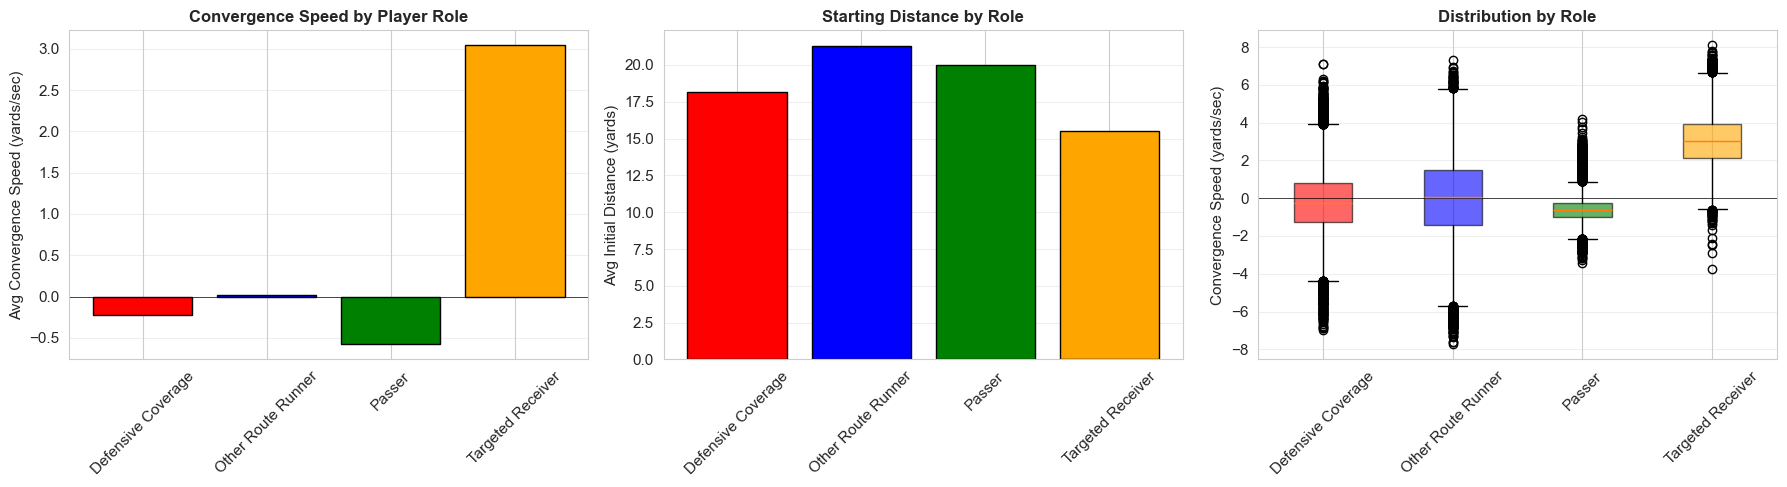


💾 Role comparison figure saved!


In [86]:
# SECTION 6.5: Compare by Player Role
print("\n" + "="*80)
print("CONVERGENCE SPEED BY PLAYER ROLE")
print("="*80)

role_stats = convergence_df.groupby('player_role').agg({
    'convergence_speed': ['mean', 'median', 'std', 'count'],
    'initial_distance': 'mean',
    'final_distance': 'mean',
    'min_distance': 'mean',
    'avg_speed': 'mean'
}).round(2)

role_stats.columns = ['avg_convergence', 'median_convergence', 'std_convergence', 
                      'count', 'avg_initial_dist', 'avg_final_dist', 'avg_min_dist', 'avg_speed']

print("\n", role_stats.to_string())

# Visualize role comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Convergence speed by role
roles = role_stats.index
avg_conv = role_stats['avg_convergence']
axes[0].bar(roles, avg_conv, color=['red', 'blue', 'green', 'orange'], edgecolor='black')
axes[0].set_ylabel('Avg Convergence Speed (yards/sec)', fontsize=11)
axes[0].set_title('Convergence Speed by Player Role', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(alpha=0.3, axis='y')
axes[0].axhline(0, color='black', linewidth=0.5)

# 2. Initial distance by role
axes[1].bar(roles, role_stats['avg_initial_dist'], 
            color=['red', 'blue', 'green', 'orange'], edgecolor='black')
axes[1].set_ylabel('Avg Initial Distance (yards)', fontsize=11)
axes[1].set_title('Starting Distance by Role', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3, axis='y')

# 3. Box plot comparison
data_by_role = [convergence_df[convergence_df['player_role'] == role]['convergence_speed'] 
                for role in roles]
bp = axes[2].boxplot(data_by_role, labels=roles, patch_artist=True)
for patch, color in zip(bp['boxes'], ['red', 'blue', 'green', 'orange']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
axes[2].set_ylabel('Convergence Speed (yards/sec)', fontsize=11)
axes[2].set_title('Distribution by Role', fontsize=12, fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(alpha=0.3, axis='y')
axes[2].axhline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.savefig(output_dir / 'convergence_by_role.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Role comparison figure saved!")

## 7. Aggregate by Player

Find the best and worst convergers!

In [40]:
# Aggregate by player (minimum 10 plays to qualify)
# NOW WITH ROLE FILTERING
MIN_PLAYS = 10

# You can analyze each role separately or together
# Option 1: Analyze defenders only
defenders_only = convergence_df[convergence_df['player_role'] == 'Defensive Coverage']

player_stats_defense = defenders_only.groupby('nfl_id').agg({
    'convergence_speed': ['mean', 'median', 'std', 'count'],
    'initial_distance': 'mean',
    'final_distance': 'mean',
    'min_distance': 'mean',
    'avg_speed': 'mean',
    'player_position': lambda x: x.mode()[0] if len(x) > 0 else None
}).reset_index()

player_stats_defense.columns = ['nfl_id', 'avg_convergence_speed', 'median_convergence_speed', 
                                'std_convergence_speed', 'num_plays', 'avg_initial_dist', 
                                'avg_final_dist', 'avg_min_dist', 'avg_player_speed', 'position']

player_stats_defense = player_stats_defense[player_stats_defense['num_plays'] >= MIN_PLAYS].copy()
player_stats_defense = player_stats_defense.sort_values('avg_convergence_speed', ascending=False)

print(f"\n" + "="*80)
print(f"TOP DEFENDERS BY CONVERGENCE SPEED")
print("="*80)
print(f"Defenders with {MIN_PLAYS}+ plays: {len(player_stats_defense)}")
print(f"\nTop 10 Fastest Converging Defenders:")
print(player_stats_defense[['nfl_id', 'position', 'avg_convergence_speed', 'num_plays']].head(10).to_string(index=False))

# Option 2: Analyze receivers
receivers_only = convergence_df[convergence_df['player_role'] == 'Targeted Receiver']

if len(receivers_only) > 0:
    player_stats_receivers = receivers_only.groupby('nfl_id').agg({
        'convergence_speed': ['mean', 'count'],
        'min_distance': 'mean',
        'player_position': lambda x: x.mode()[0] if len(x) > 0 else None
    }).reset_index()
    
    player_stats_receivers.columns = ['nfl_id', 'avg_convergence_speed', 'num_plays', 'avg_min_dist', 'position']
    player_stats_receivers = player_stats_receivers[player_stats_receivers['num_plays'] >= MIN_PLAYS].copy()
    player_stats_receivers = player_stats_receivers.sort_values('avg_convergence_speed', ascending=False)
    
    print(f"\n" + "="*80)
    print(f"TOP RECEIVERS BY CONVERGENCE SPEED")
    print("="*80)
    print(f"Receivers with {MIN_PLAYS}+ plays: {len(player_stats_receivers)}")
    print(f"\nTop 10 Fastest Converging Receivers:")
    print(player_stats_receivers[['nfl_id', 'position', 'avg_convergence_speed', 'num_plays', 'avg_min_dist']].head(10).to_string(index=False))

# Save both
player_stats_defense.to_csv(output_dir / 'defender_convergence_rankings.csv', index=False)
if len(receivers_only) > 0:
    player_stats_receivers.to_csv(output_dir / 'receiver_convergence_rankings.csv', index=False)


TOP DEFENDERS BY CONVERGENCE SPEED
Defenders with 10+ plays: 550

Top 10 Fastest Converging Defenders:
 nfl_id position  avg_convergence_speed  num_plays
  44813       DE               0.887741         15
  55892       DE               0.816102         13
  42381       DE               0.768296         23
  53441      OLB               0.763817         14
  44915       DE               0.682304         20
  52456       DE               0.622593         20
  52475      OLB               0.601030         13
  56111       CB               0.590095         11
  52515      ILB               0.531089         26
  46630       CB               0.489535         26

TOP RECEIVERS BY CONVERGENCE SPEED
Receivers with 10+ plays: 304

Top 10 Fastest Converging Receivers:
 nfl_id position  avg_convergence_speed  num_plays  avg_min_dist
  40026       WR               4.656425         11     17.995817
  54483       WR               4.399243         23     12.660846
  55965       WR               4.371

In [88]:
receivers_only.head()

,week,game_id,play_id,nfl_id,player_role,player_position,initial_distance,final_distance,min_distance,distance_change,time_elapsed,convergence_speed,avg_speed,max_speed,num_frames
8,1,2023090700,101,44930,Targeted Receiver,WR,25.449655,17.986063,17.986063,-7.463592,2.6,2.870612,4.611154,7.90,26
21,1,2023090700,194,41325,Targeted Receiver,RB,10.373141,4.068413,4.068413,-6.304729,3.2,1.970228,2.723750,6.13,32
34,1,2023090700,219,53591,Targeted Receiver,TE,4.794165,1.276636,1.276636,-3.517528,1.7,2.069134,2.780000,4.69,17
45,1,2023090700,361,38696,Targeted Receiver,WR,12.527606,8.134531,4.191515,-4.393075,5.1,0.861387,3.500980,6.78,51
56,1,2023090700,436,53541,Targeted Receiver,WR,5.540297,3.220062,3.220062,-2.320235,2.0,1.160118,2.512000,4.43,20


In [41]:
# NEW INSIGHT: Compare roles
print(f"\n5. ROLE COMPARISON:")

def_avg = convergence_df[convergence_df['player_role'] == 'Defensive Coverage']['convergence_speed'].mean()
rec_avg = convergence_df[convergence_df['player_role'] == 'Targeted Receiver']['convergence_speed'].mean()

print(f"   Defensive Coverage avg: {def_avg:.2f} yards/sec")
print(f"   Targeted Receiver avg: {rec_avg:.2f} yards/sec")
print(f"   → Receivers converge {rec_avg - def_avg:+.2f} yards/sec {'faster' if rec_avg > def_avg else 'slower'} than defenders")

# Success rates
def_success = (convergence_df[convergence_df['player_role'] == 'Defensive Coverage']['min_distance'] < 5).mean()
rec_success = (convergence_df[convergence_df['player_role'] == 'Targeted Receiver']['min_distance'] < 5).mean()

print(f"\n   Ball arrival success rate (<5 yards):")
print(f"   Defenders: {def_success * 100:.1f}%")
print(f"   Receivers: {rec_success * 100:.1f}%")


5. ROLE COMPARISON:
   Defensive Coverage avg: -0.22 yards/sec
   Targeted Receiver avg: 3.04 yards/sec
   → Receivers converge +3.26 yards/sec faster than defenders

   Ball arrival success rate (<5 yards):
   Defenders: 10.2%
   Receivers: 46.7%


In [44]:
# Bottom 10 (slowest convergers)
print(f"\nBottom 10 Slowest Convergers:")
print("="*80)
print(player_stats_defense[['nfl_id', 'position', 'avg_convergence_speed', 'num_plays', 'avg_player_speed']].tail(10).to_string(index=False))
print(f"\nBottom 10 Slowest Convergers:")
print("="*80)
print(player_stats_receivers[['nfl_id', 'position', 'avg_convergence_speed', 'num_plays', 'avg_min_dist']].tail(10).to_string(index=False))


Bottom 10 Slowest Convergers:
 nfl_id position  avg_convergence_speed  num_plays  avg_player_speed
  55054       SS              -1.031839         32          2.431789
  47837       FS              -1.051022         72          2.950534
  54617       FS              -1.057867         70          2.773880
  47844       FS              -1.058050        172          3.072527
  43395       SS              -1.070136         67          2.429697
  43413       SS              -1.073926         32          2.390724
  46535       CB              -1.078428         19          2.900260
  56586       FS              -1.100452         16          2.416245
  35452       DE              -1.149457         11          2.035633
  46349       FS              -1.259169         21          2.155093

Bottom 10 Slowest Convergers:
 nfl_id position  avg_convergence_speed  num_plays  avg_min_dist
  44856       TE               2.321290         57      4.402715
  42589       TE               2.315199         1

In [45]:
# Save player rankings
player_stats_defense.to_csv(output_dir / 'player_defense_convergence_rankings.csv', index=False)
player_stats_receivers.to_csv(output_dir / 'player_recievers_convergence_rankings.csv', index=False)
print(f"\n💾 Player rankings saved to: {output_dir / 'player_convergence_rankings.csv'}")


💾 Player rankings saved to: ..\data\processed\player_convergence_rankings.csv


## 8. Aggregate by Position

Which positions are best at converging?

In [46]:
# Aggregate by position
position_stats = convergence_df.groupby('player_position').agg({
    'convergence_speed': ['mean', 'median', 'std'],
    'nfl_id': 'count',
    'initial_distance': 'mean',
    'final_distance': 'mean',
    'avg_speed': 'mean'
}).reset_index()

# Flatten column names
position_stats.columns = ['position', 'avg_convergence_speed', 'median_convergence_speed',
                          'std_convergence_speed', 'num_instances', 'avg_initial_dist',
                          'avg_final_dist', 'avg_player_speed']

# Filter to positions with at least 50 instances
position_stats = position_stats[position_stats['num_instances'] >= 50].copy()
position_stats = position_stats.sort_values('avg_convergence_speed', ascending=False)

print("Convergence Speed by Position:")
print("="*80)
print(position_stats[['position', 'avg_convergence_speed', 'num_instances', 'avg_player_speed']].to_string(index=False))

Convergence Speed by Position:
position  avg_convergence_speed  num_instances  avg_player_speed
      WR               0.815808          38002          4.146034
      TE               0.665795          14856          3.587409
      DT               0.421639            117          1.702332
      RB               0.266188          11014          3.261499
      DE               0.221009            596          1.980892
      FB              -0.035364            658          3.559418
     MLB              -0.088151           7065          2.108283
     ILB              -0.096745          10405          2.129428
     OLB              -0.104622           7297          2.136691
      CB              -0.106451          37561          2.553392
       S              -0.245090            481          2.683011
      SS              -0.468643          13764          2.477853
      FS              -0.470381          17018          2.433517
      QB              -0.567379          14266          1.6

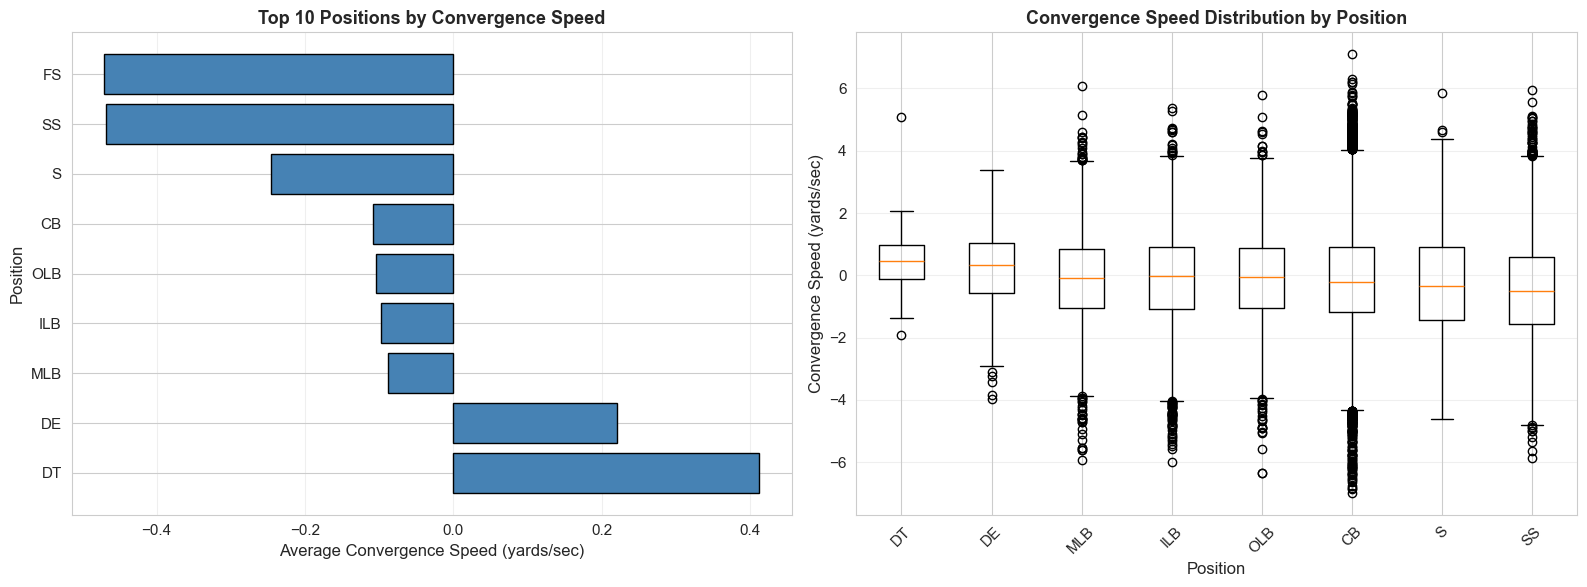


💾 Figure saved!


In [22]:
# Visualize by position
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of convergence speed by position
top_positions = position_stats.nlargest(10, 'avg_convergence_speed')
axes[0].barh(top_positions['position'], top_positions['avg_convergence_speed'], 
             color='steelblue', edgecolor='black')
axes[0].set_xlabel('Average Convergence Speed (yards/sec)', fontsize=12)
axes[0].set_ylabel('Position', fontsize=12)
axes[0].set_title('Top 10 Positions by Convergence Speed', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3, axis='x')

# Box plot by position (top 8 positions)
top_8_positions = position_stats.nlargest(8, 'avg_convergence_speed')['position'].tolist()
data_to_plot = [convergence_df[convergence_df['player_position'] == pos]['convergence_speed'] 
                for pos in top_8_positions]
axes[1].boxplot(data_to_plot, labels=top_8_positions)
axes[1].set_ylabel('Convergence Speed (yards/sec)', fontsize=12)
axes[1].set_xlabel('Position', fontsize=12)
axes[1].set_title('Convergence Speed Distribution by Position', fontsize=13, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(output_dir / 'convergence_by_position.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Figure saved!")

## 9. Key Insights and Patterns

In [63]:
# KEY INSIGHTS - ANALYZED BY ROLE
print("="*80)
print("KEY INSIGHTS BY PLAYER ROLE")
print("="*80)

roles_to_analyze = ['Defensive Coverage', 'Targeted Receiver', 'Other Route Runner', 'Passer']

for role in roles_to_analyze:
    role_data = convergence_df[convergence_df['player_role'] == role]
    
    if len(role_data) == 0:
        continue
    
    print(f"\n{'='*80}")
    print(f"{role.upper()} ({len(role_data):,} instances)")
    print('='*80)
    
    # Insight 1: Speed vs Convergence correlation
    correlation = role_data['avg_speed'].corr(role_data['convergence_speed'])
    print(f"\n1. SPEED vs CONVERGENCE:")
    print(f"   Correlation: {correlation:.3f}")
    if correlation > 0.5:
        print("   → Faster players converge significantly better")
    elif correlation > 0.3:
        print("   → Moderate relationship between speed and convergence")
    elif correlation > -0.3:
        print("   → Weak relationship - positioning matters more than speed")
    else:
        print("   → Negative correlation - faster players move away more")
    
    # Insight 2: Distance scenarios
    print(f"\n2. DISTANCE SCENARIOS:")
    
    close_start = role_data[role_data['initial_distance'] < 10]
    far_start = role_data[role_data['initial_distance'] > 20]
    
    if len(close_start) > 0:
        print(f"   Starting CLOSE (<10 yards): {len(close_start):,} instances")
        print(f"     • Avg convergence: {close_start['convergence_speed'].mean():.2f} yards/sec")
        print(f"     • Success rate reaching ball (<5 yards): {(close_start['min_distance'] < 5).mean() * 100:.1f}%")
    
    if len(far_start) > 0:
        print(f"\n   Starting FAR (>20 yards): {len(far_start):,} instances")
        print(f"     • Avg convergence: {far_start['convergence_speed'].mean():.2f} yards/sec")
        print(f"     • Success rate reaching ball (<5 yards): {(far_start['min_distance'] < 5).mean() * 100:.1f}%")
    
    # Insight 3: Convergence direction
    print(f"\n3. CONVERGENCE DIRECTION:")
    
    positive_conv = role_data[role_data['convergence_speed'] > 0]
    negative_conv = role_data[role_data['convergence_speed'] < 0]
    
    print(f"   Moving TOWARD ball: {len(positive_conv):,} ({len(positive_conv)/len(role_data)*100:.1f}%)")
    if len(positive_conv) > 0:
        print(f"     • Avg convergence speed: {positive_conv['convergence_speed'].mean():.2f} yards/sec")
    
    print(f"\n   Moving AWAY from ball: {len(negative_conv):,} ({len(negative_conv)/len(role_data)*100:.1f}%)")
    if len(negative_conv) > 0:
        print(f"     • Avg divergence speed: {negative_conv['convergence_speed'].mean():.2f} yards/sec")
    
    # Insight 4: Elite vs Average for this role
    print(f"\n4. ELITE vs AVERAGE {role.upper()}:")
    
    top_10_pct = role_data['convergence_speed'].quantile(0.90)
    elite = role_data[role_data['convergence_speed'] >= top_10_pct]
    average = role_data[(role_data['convergence_speed'] >= role_data['convergence_speed'].quantile(0.40)) & 
                       (role_data['convergence_speed'] <= role_data['convergence_speed'].quantile(0.60))]
    
    if len(elite) > 0:
        print(f"   ELITE (top 10%):")
        print(f"     • Convergence speed: {elite['convergence_speed'].mean():.2f} yards/sec")
        print(f"     • Avg player speed: {elite['avg_speed'].mean():.2f} yards/sec")
        print(f"     • Closest approach: {elite['min_distance'].mean():.2f} yards")
    
    if len(average) > 0:
        print(f"\n   AVERAGE (40-60th percentile):")
        print(f"     • Convergence speed: {average['convergence_speed'].mean():.2f} yards/sec")
        print(f"     • Avg player speed: {average['avg_speed'].mean():.2f} yards/sec")
        print(f"     • Closest approach: {average['min_distance'].mean():.2f} yards")
    
    if len(elite) > 0 and len(average) > 0:
        diff = elite['convergence_speed'].mean() - average['convergence_speed'].mean()
        print(f"\n   → Elite {role} converge {diff:+.2f} yards/sec compared to average")

# Cross-role comparison
print(f"\n\n{'='*80}")
print("CROSS-ROLE COMPARISON")
print('='*80)

print("\nAverage convergence speed by role:")
for role in roles_to_analyze:
    role_data = convergence_df[convergence_df['player_role'] == role]
    if len(role_data) > 0:
        avg_conv = role_data['convergence_speed'].mean()
        print(f"  {role:<25}: {avg_conv:>6.2f} yards/sec")

print("\nSuccess rate (getting within 5 yards) by role:")
for role in roles_to_analyze:
    role_data = convergence_df[convergence_df['player_role'] == role]
    if len(role_data) > 0:
        success_rate = (role_data['min_distance'] < 5).mean() * 100
        print(f"  {role:<25}: {success_rate:>5.1f}%")

KEY INSIGHTS BY PLAYER ROLE

DEFENSIVE COVERAGE (94,293 instances)

1. SPEED vs CONVERGENCE:
   Correlation: -0.034
   → Weak relationship - positioning matters more than speed

2. DISTANCE SCENARIOS:
   Starting CLOSE (<10 yards): 22,721 instances
     • Avg convergence: -0.87 yards/sec
     • Success rate reaching ball (<5 yards): 39.7%

   Starting FAR (>20 yards): 36,054 instances
     • Avg convergence: 0.19 yards/sec
     • Success rate reaching ball (<5 yards): 0.1%

3. CONVERGENCE DIRECTION:
   Moving TOWARD ball: 40,837 (43.3%)
     • Avg convergence speed: 1.19 yards/sec

   Moving AWAY from ball: 53,455 (56.7%)
     • Avg divergence speed: -1.30 yards/sec

4. ELITE vs AVERAGE DEFENSIVE COVERAGE:
   ELITE (top 10%):
     • Convergence speed: 2.60 yards/sec
     • Avg player speed: 3.34 yards/sec
     • Closest approach: 16.20 yards

   AVERAGE (40-60th percentile):
     • Convergence speed: -0.26 yards/sec
     • Avg player speed: 1.89 yards/sec
     • Closest approach: 17.93

## 10. Situational Analysis

If supplementary data has additional context (down, distance, etc.), analyze by situation.

In [64]:
# Check if we can merge with supplementary data for additional context
print("Checking supplementary data merge possibilities...")
print("="*80)

# Try to identify common columns
common_cols = set(convergence_df.columns).intersection(set(supp_data.columns))
print(f"\nCommon columns: {common_cols}")

# If we have game_id and play_id in both, we can merge
if 'game_id' in common_cols and 'play_id' in common_cols:
    print("\n✅ Can merge on game_id and play_id!")
    
    # Merge
    convergence_enriched = convergence_df.merge(
        supp_data,
        on=['game_id', 'play_id'],
        how='left'
    )
    
    print(f"\nEnriched data shape: {convergence_enriched.shape}")
    print(f"New columns from supplementary data:")
    new_cols = set(convergence_enriched.columns) - set(convergence_df.columns)
    for col in sorted(new_cols):
        print(f"  • {col}")
else:
    print("\n⚠️  Cannot directly merge - different column names or structure")
    convergence_enriched = convergence_df.copy()

Checking supplementary data merge possibilities...

Common columns: {'game_id', 'week', 'play_id'}

✅ Can merge on game_id and play_id!

Enriched data shape: (173150, 54)
New columns from supplementary data:
  • defenders_in_the_box
  • defensive_team
  • down
  • dropback_distance
  • dropback_type
  • expected_points
  • expected_points_added
  • game_clock
  • game_date
  • game_time_eastern
  • home_team_abbr
  • home_team_win_probability_added
  • offense_formation
  • pass_length
  • pass_location_type
  • pass_result
  • penalty_yards
  • play_action
  • play_description
  • play_nullified_by_penalty
  • possession_team
  • pre_penalty_yards_gained
  • pre_snap_home_score
  • pre_snap_home_team_win_probability
  • pre_snap_visitor_score
  • pre_snap_visitor_team_win_probability
  • quarter
  • receiver_alignment
  • route_of_targeted_receiver
  • season
  • team_coverage_man_zone
  • team_coverage_type
  • visitor_team_abbr
  • visitor_team_win_probility_added
  • week_x
  • wee

## 11. Create Final Visualizations

In [68]:
# Create combined player stats for all roles
player_stats_all = convergence_df.groupby('nfl_id').agg({
    'convergence_speed': ['mean', 'median', 'std', 'count'],
    'initial_distance': 'mean',
    'final_distance': 'mean',
    'min_distance': 'mean',
    'avg_speed': 'mean',
    'player_position': lambda x: x.mode()[0] if len(x) > 0 else None,
    'player_role': lambda x: x.mode()[0] if len(x) > 0 else None  # Most common role
}).reset_index()

player_stats_all.columns = ['nfl_id', 'avg_convergence_speed', 'median_convergence_speed', 
                            'std_convergence_speed', 'num_plays', 'avg_initial_dist', 
                            'avg_final_dist', 'avg_min_dist', 'avg_player_speed', 
                            'position', 'role']

player_stats_all = player_stats_all[player_stats_all['num_plays'] >= 10].copy()
player_stats_all = player_stats_all.sort_values('avg_convergence_speed', ascending=False)

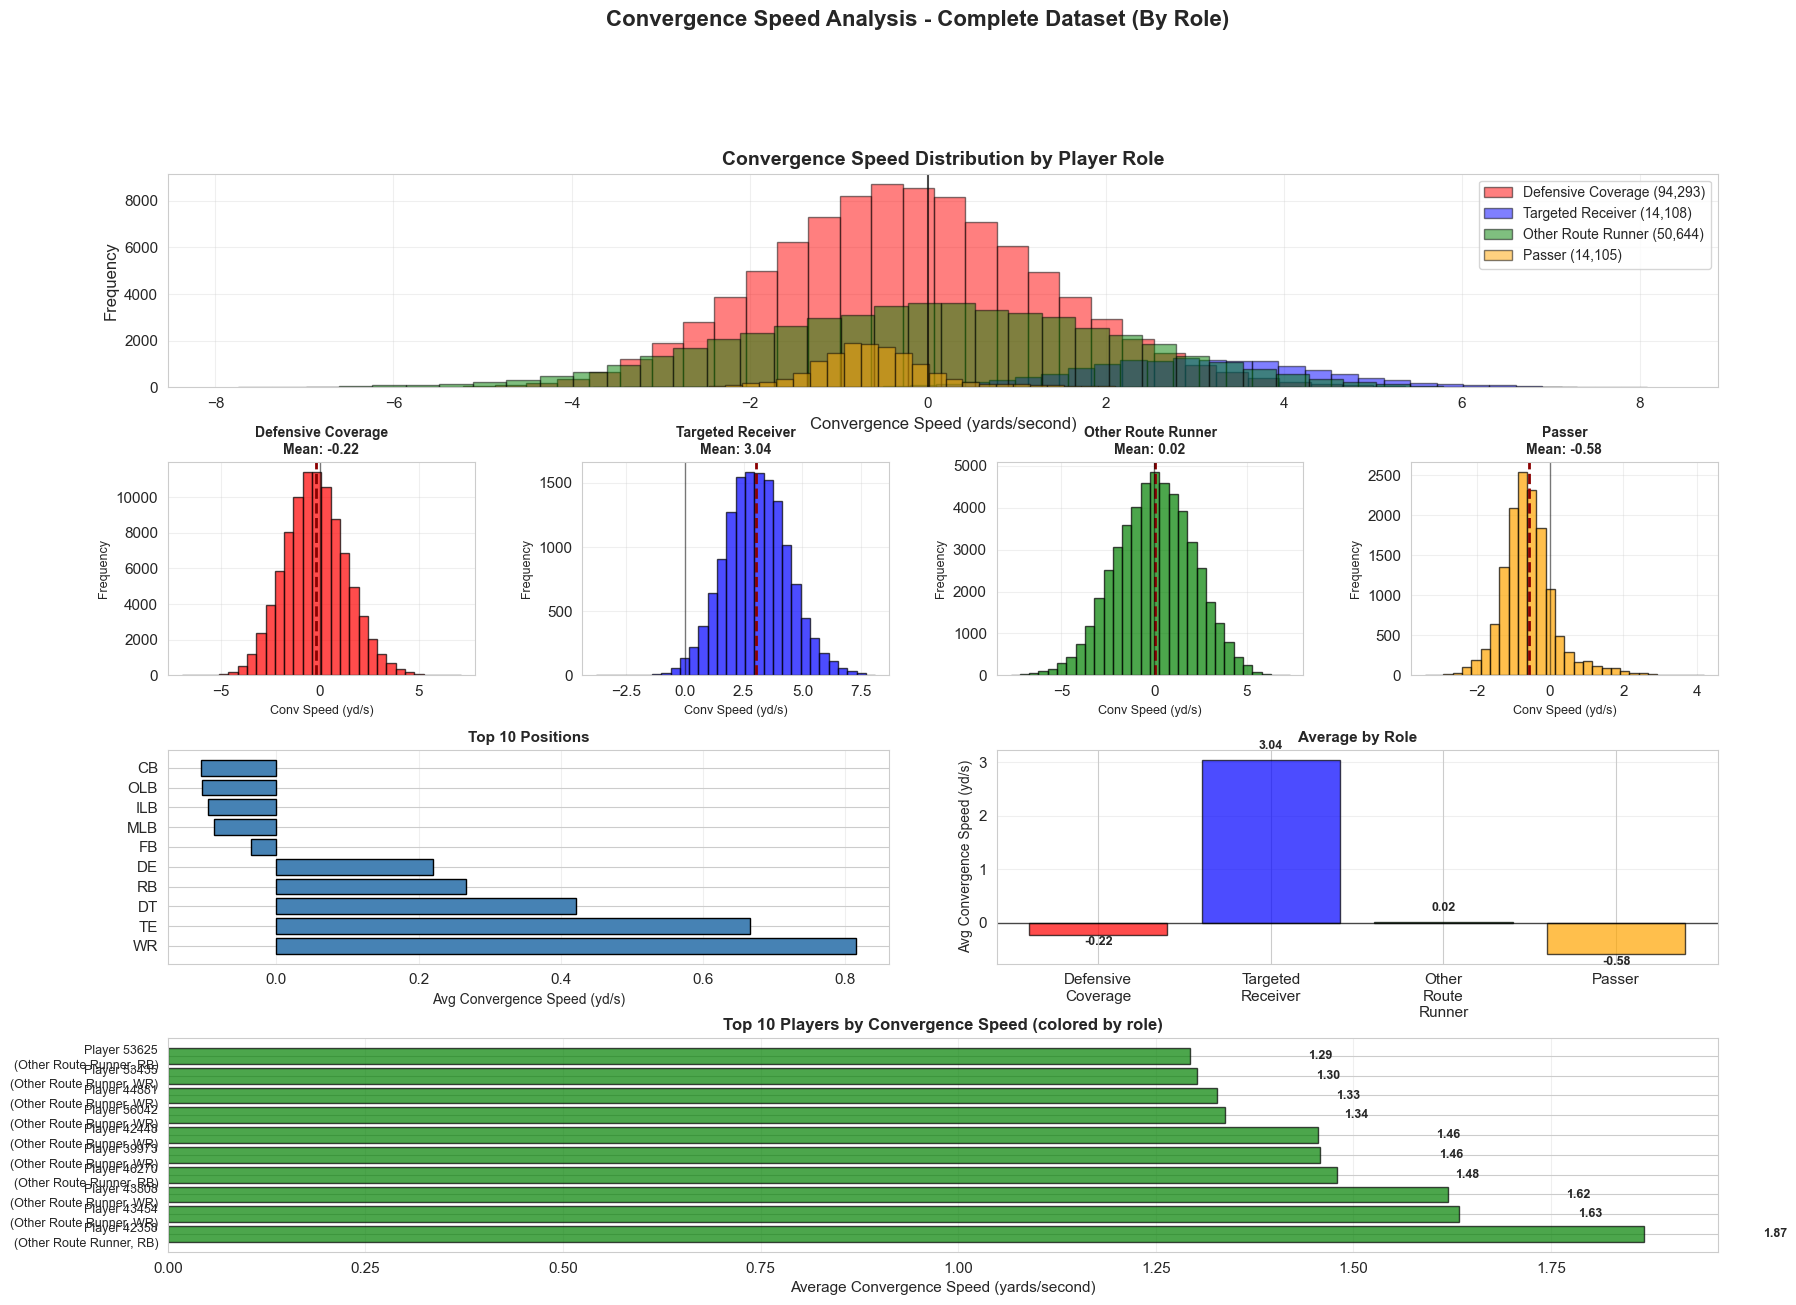


💾 Comprehensive visualization saved!


In [69]:
# Create comprehensive visualization dashboard BY ROLE
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 4, hspace=0.35, wspace=0.35)

role_colors = {'Defensive Coverage': 'red', 'Targeted Receiver': 'blue', 
               'Other Route Runner': 'green', 'Passer': 'orange'}

# 1. Overall distribution by role (top row, spans all columns)
ax1 = fig.add_subplot(gs[0, :])
for role in roles_to_analyze:
    role_data = convergence_df[convergence_df['player_role'] == role]
    if len(role_data) > 0:
        ax1.hist(role_data['convergence_speed'], bins=40, alpha=0.5,
                label=f"{role} ({len(role_data):,})", 
                color=role_colors[role], edgecolor='black')

ax1.axvline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
ax1.set_xlabel('Convergence Speed (yards/second)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Convergence Speed Distribution by Player Role', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10, loc='upper right')
ax1.grid(alpha=0.3)

# 2-5. Individual role distributions (second row)
for idx, role in enumerate(roles_to_analyze):
    ax = fig.add_subplot(gs[1, idx])
    role_data = convergence_df[convergence_df['player_role'] == role]
    
    if len(role_data) > 0:
        ax.hist(role_data['convergence_speed'], bins=30, 
               color=role_colors[role], edgecolor='black', alpha=0.7)
        ax.axvline(role_data['convergence_speed'].mean(), color='darkred', 
                  linestyle='--', linewidth=2)
        ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        ax.set_xlabel('Conv Speed (yd/s)', fontsize=9)
        ax.set_ylabel('Frequency', fontsize=9)
        ax.set_title(f'{role}\nMean: {role_data["convergence_speed"].mean():.2f}', 
                    fontsize=10, fontweight='bold')
        ax.grid(alpha=0.3)

# 6. Top positions (third row, left)
ax6 = fig.add_subplot(gs[2, :2])
top_pos = position_stats.nlargest(10, 'avg_convergence_speed')
ax6.barh(top_pos['position'], top_pos['avg_convergence_speed'], 
        color='steelblue', edgecolor='black')
ax6.set_xlabel('Avg Convergence Speed (yd/s)', fontsize=10)
ax6.set_title('Top 10 Positions', fontsize=11, fontweight='bold')
ax6.grid(alpha=0.3, axis='x')

# 7. Role comparison bar chart (third row, right)
ax7 = fig.add_subplot(gs[2, 2:])
role_avgs = [convergence_df[convergence_df['player_role'] == role]['convergence_speed'].mean() 
             for role in roles_to_analyze]
role_labels = [role.replace(' ', '\n') for role in roles_to_analyze]
colors_list = [role_colors[role] for role in roles_to_analyze]

ax7.bar(role_labels, role_avgs, color=colors_list, edgecolor='black', alpha=0.7)
ax7.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.7)
ax7.set_ylabel('Avg Convergence Speed (yd/s)', fontsize=10)
ax7.set_title('Average by Role', fontsize=11, fontweight='bold')
ax7.grid(alpha=0.3, axis='y')

# Add value labels on bars
for i, (val, label) in enumerate(zip(role_avgs, role_labels)):
    ax7.text(i, val + 0.2 if val > 0 else val - 0.2, f'{val:.2f}', 
            ha='center', fontsize=9, fontweight='bold')

# 8. Top 10 players (bottom row)
ax8 = fig.add_subplot(gs[3, :])
top_players = player_stats_all.nlargest(10, 'avg_convergence_speed')
colors_gradient = plt.cm.RdYlGn(np.linspace(0.3, 0.9, 10))

# Color bars by player role
bar_colors = [role_colors.get(role, 'gray') for role in top_players['role']]
bars = ax8.barh(range(10), top_players['avg_convergence_speed'].values, 
               color=bar_colors, edgecolor='black', alpha=0.7)

ax8.set_yticks(range(10))
ax8.set_yticklabels([f"Player {int(nfl_id)}\n({role}, {pos})" 
                     for nfl_id, role, pos in zip(top_players['nfl_id'], 
                                                  top_players['role'],
                                                  top_players['position'])],
                    fontsize=9)
ax8.set_xlabel('Average Convergence Speed (yards/second)', fontsize=11)
ax8.set_title('Top 10 Players by Convergence Speed (colored by role)', 
             fontsize=12, fontweight='bold')
ax8.grid(alpha=0.3, axis='x')

# Add values on bars
for i, (bar, val) in enumerate(zip(bars, top_players['avg_convergence_speed'].values)):
    ax8.text(val + 0.15, i, f'{val:.2f}', va='center', fontsize=9, fontweight='bold')

plt.suptitle('Convergence Speed Analysis - Complete Dataset (By Role)', 
            fontsize=16, fontweight='bold', y=0.997)

plt.savefig(output_dir / 'comprehensive_convergence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Comprehensive visualization saved!")

## 12. Summary Report

In [66]:
# Generate comprehensive summary report by role
print("="*80)
print("PLAYER CONVERGENCE SPEED - FINAL SUMMARY REPORT")
print("="*80)

roles_to_analyze = ['Defensive Coverage', 'Targeted Receiver', 'Other Route Runner', 'Passer']

print(f"""
DATASET COVERAGE:
- Total plays analyzed: {convergence_df.groupby(['game_id', 'play_id']).ngroups:,}
- Total player instances: {len(convergence_df):,}
- Unique players: {convergence_df['nfl_id'].nunique():,}
- Weeks covered: {sorted(convergence_df['week'].unique())}
- Positions analyzed: {convergence_df['player_position'].nunique()}

BREAKDOWN BY PLAYER ROLE:
""")

for role in roles_to_analyze:
    role_data = convergence_df[convergence_df['player_role'] == role]
    if len(role_data) > 0:
        print(f"  {role}: {len(role_data):,} instances ({len(role_data)/len(convergence_df)*100:.1f}%)")

print(f"""
\nKEY METRIC - CONVERGENCE SPEED:
- Definition: Rate at which players move toward/away from ball landing spot
- Units: Yards per second (positive = moving closer, negative = moving away)
- Overall Average: {convergence_df['convergence_speed'].mean():.2f} yards/sec
- Overall Median: {convergence_df['convergence_speed'].median():.2f} yards/sec
- Standard Deviation: {convergence_df['convergence_speed'].std():.2f}

CONVERGENCE SPEED BY ROLE:
""")

for role in roles_to_analyze:
    role_data = convergence_df[convergence_df['player_role'] == role]
    if len(role_data) > 0:
        print(f"  {role}:")
        print(f"    • Average: {role_data['convergence_speed'].mean():.2f} yards/sec")
        print(f"    • Median: {role_data['convergence_speed'].median():.2f} yards/sec")
        print(f"    • % moving toward ball: {(role_data['convergence_speed'] > 0).sum() / len(role_data) * 100:.1f}%")

print(f"""
\nTOP PERFORMING POSITIONS (Overall):
""")

top_3_pos = position_stats.nlargest(3, 'avg_convergence_speed')
for idx, row in top_3_pos.iterrows():
    print(f"  {row['position']}: {row['avg_convergence_speed']:.2f} yards/sec ({int(row['num_instances'])} instances)")

print(f"""
\nTOP PERFORMERS BY ROLE:
""")

# Top performers for each role
for role in ['Defensive Coverage', 'Targeted Receiver']:
    role_data = convergence_df[convergence_df['player_role'] == role]
    if len(role_data) > 0:
        role_players = role_data.groupby('nfl_id').agg({
            'convergence_speed': 'mean',
            'player_position': lambda x: x.mode()[0] if len(x) > 0 else None,
            'game_id': 'count'
        }).reset_index()
        role_players.columns = ['nfl_id', 'avg_conv_speed', 'position', 'num_plays']
        role_players = role_players[role_players['num_plays'] >= 10].nlargest(5, 'avg_conv_speed')
        
        print(f"\n  {role} (Top 5):")
        for idx, row in role_players.iterrows():
            print(f"    Player {int(row['nfl_id'])} ({row['position']}): {row['avg_conv_speed']:.2f} yards/sec ({int(row['num_plays'])} plays)")

print(f"""
\nKEY FINDINGS BY ROLE:
""")

for role in roles_to_analyze:
    role_data = convergence_df[convergence_df['player_role'] == role]
    if len(role_data) > 0:
        correlation = role_data['avg_speed'].corr(role_data['convergence_speed'])
        positive_pct = (role_data['convergence_speed'] > 0).sum() / len(role_data) * 100
        success_rate = (role_data['min_distance'] < 5).mean() * 100
        
        print(f"\n{role}:")
        print(f"  • Speed correlation: {correlation:.3f}")
        print(f"  • Moving toward ball: {positive_pct:.1f}%")
        print(f"  • Success rate (within 5 yards): {success_rate:.1f}%")
        print(f"  • Avg starting distance: {role_data['initial_distance'].mean():.2f} yards")

print(f"""
\nCROSS-ROLE INSIGHTS:
1. Receivers vs Defenders:
   → Receivers converge at {convergence_df[convergence_df['player_role'] == 'Targeted Receiver']['convergence_speed'].mean():.2f} yards/sec
   → Defenders converge at {convergence_df[convergence_df['player_role'] == 'Defensive Coverage']['convergence_speed'].mean():.2f} yards/sec
   → Difference: {convergence_df[convergence_df['player_role'] == 'Targeted Receiver']['convergence_speed'].mean() - convergence_df[convergence_df['player_role'] == 'Defensive Coverage']['convergence_speed'].mean():.2f} yards/sec

2. Success Rates (getting within 5 yards):
   → Receivers: {(convergence_df[convergence_df['player_role'] == 'Targeted Receiver']['min_distance'] < 5).mean() * 100:.1f}%
   → Defenders: {(convergence_df[convergence_df['player_role'] == 'Defensive Coverage']['min_distance'] < 5).mean() * 100:.1f}%

3. Distance Impact (Defenders):
   → Starting close (<10 yards): {convergence_df[(convergence_df['player_role'] == 'Defensive Coverage') & (convergence_df['initial_distance'] < 10)]['convergence_speed'].mean():.2f} yards/sec
   → Starting far (>20 yards): {convergence_df[(convergence_df['player_role'] == 'Defensive Coverage') & (convergence_df['initial_distance'] > 20)]['convergence_speed'].mean():.2f} yards/sec

ACTIONABLE INSIGHTS FOR COACHES:

DEFENSE:
- Elite defenders (top 10%) converge {convergence_df[convergence_df['player_role'] == 'Defensive Coverage']['convergence_speed'].quantile(0.90):.2f} yards/sec
- Average defenders converge {convergence_df[convergence_df['player_role'] == 'Defensive Coverage']['convergence_speed'].quantile(0.50):.2f} yards/sec
- Gap: {convergence_df[convergence_df['player_role'] == 'Defensive Coverage']['convergence_speed'].quantile(0.90) - convergence_df[convergence_df['player_role'] == 'Defensive Coverage']['convergence_speed'].quantile(0.50):.2f} yards/sec difference

OFFENSE:
- Elite receivers converge {convergence_df[convergence_df['player_role'] == 'Targeted Receiver']['convergence_speed'].quantile(0.90):.2f} yards/sec
- Speed matters: {convergence_df[convergence_df['player_role'] == 'Targeted Receiver']['avg_speed'].corr(convergence_df[convergence_df['player_role'] == 'Targeted Receiver']['convergence_speed']):.3f} correlation with convergence

FILES GENERATED:
✓ convergence_speed_all_plays.csv - Complete play-by-play data
✓ defender_convergence_rankings.csv - Defender rankings
✓ receiver_convergence_rankings.csv - Receiver rankings  
✓ position_convergence_stats.csv - Position analysis
✓ summary_statistics_by_role.csv - Role-based summary
✓ convergence_by_role.png - Role comparison visualization
✓ speed_vs_convergence_by_role.png - Speed analysis by role
✓ convergence_by_week_by_role.png - Weekly trends by role
✓ initial_vs_final_distance_by_role.png - Distance patterns by role
✓ comprehensive_convergence_analysis.png - Full dashboard
""")

print("="*80)
print("✅ ANALYSIS COMPLETE!")
print("="*80)

PLAYER CONVERGENCE SPEED - FINAL SUMMARY REPORT

DATASET COVERAGE:
- Total plays analyzed: 14,108
- Total player instances: 173,150
- Unique players: 1,384
- Weeks covered: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18)]
- Positions analyzed: 19

BREAKDOWN BY PLAYER ROLE:

  Defensive Coverage: 94,293 instances (54.5%)
  Targeted Receiver: 14,108 instances (8.1%)
  Other Route Runner: 50,644 instances (29.2%)
  Passer: 14,105 instances (8.1%)


KEY METRIC - CONVERGENCE SPEED:
- Definition: Rate at which players move toward/away from ball landing spot
- Units: Yards per second (positive = moving closer, negative = moving away)
- Overall Average: 0.09 yards/sec
- Overall Median: -0.10 yards/sec
- Standard Deviation: 1.89

CONVERGENCE SPEED BY ROLE:

  Defensive Coverage:
    • Average: -0.22 yar

## 13. Export for Writeup

Prepare final datasets and figures for submission.

In [67]:
# Save position statistics
position_stats.to_csv(output_dir / 'position_convergence_stats.csv', index=False)

# Save role-based summary statistics
role_summary = convergence_df.groupby('player_role').agg({
    'convergence_speed': ['mean', 'median', 'std', 'count'],
    'avg_speed': 'mean',
    'initial_distance': 'mean',
    'final_distance': 'mean',
    'min_distance': 'mean',
    'nfl_id': 'nunique'
}).round(2)

role_summary.columns = ['Mean Conv Speed', 'Median Conv Speed', 'Std Conv Speed', 
                        'Total Instances', 'Avg Player Speed', 'Avg Initial Dist',
                        'Avg Final Dist', 'Avg Min Dist', 'Unique Players']
role_summary.to_csv(output_dir / 'summary_statistics_by_role.csv')

# Save overall summary statistics
summary_stats = pd.DataFrame({
    'Metric': ['Mean Convergence Speed', 'Median Convergence Speed', 'Std Dev',
               'Total Plays', 'Total Player Instances', 'Unique Players',
               'Positive Convergence %', 'Defender Speed Correlation',
               'Receiver Speed Correlation'],
    'Value': [
        f"{convergence_df['convergence_speed'].mean():.2f} yards/sec",
        f"{convergence_df['convergence_speed'].median():.2f} yards/sec",
        f"{convergence_df['convergence_speed'].std():.2f}",
        f"{convergence_df.groupby(['game_id', 'play_id']).ngroups:,}",
        f"{len(convergence_df):,}",
        f"{convergence_df['nfl_id'].nunique():,}",
        f"{(convergence_df['convergence_speed'] > 0).sum() / len(convergence_df) * 100:.1f}%",
        f"{convergence_df[convergence_df['player_role'] == 'Defensive Coverage']['avg_speed'].corr(convergence_df[convergence_df['player_role'] == 'Defensive Coverage']['convergence_speed']):.3f}",
        f"{convergence_df[convergence_df['player_role'] == 'Targeted Receiver']['avg_speed'].corr(convergence_df[convergence_df['player_role'] == 'Targeted Receiver']['convergence_speed']):.3f}"
    ]
})

summary_stats.to_csv(output_dir / 'summary_statistics.csv', index=False)

print("📊 All files exported to:")
print(f"   {output_dir.absolute()}")
print("\nFiles created:")
for file in sorted(output_dir.glob('*')):
    size_mb = file.stat().st_size / (1024**2)
    print(f"   ✓ {file.name:<50} ({size_mb:>6.2f} MB)")

📊 All files exported to:
   d:\PyScripts\NFL-Big-Data-Bowl-2026-Analytics\notebooks\..\data\processed

Files created:
   ✓ comprehensive_convergence_analysis.png             (  0.70 MB)
   ✓ convergence_by_position.png                        (  0.24 MB)
   ✓ convergence_by_role.png                            (  0.27 MB)
   ✓ convergence_by_role_distributions.png              (  0.34 MB)
   ✓ convergence_by_week_by_role.png                    (  0.50 MB)
   ✓ convergence_speed_all_plays.csv                    ( 27.91 MB)
   ✓ defender_convergence_rankings.csv                  (  0.08 MB)
   ✓ initial_vs_final_distance_by_role.png              (  3.04 MB)
   ✓ overall_convergence_statistics.png                 (  2.40 MB)
   ✓ player_convergence_rankings.csv                    (  0.08 MB)
   ✓ player_defense_convergence_rankings.csv            (  0.08 MB)
   ✓ player_recievers_convergence_rankings.csv          (  0.01 MB)
   ✓ position_convergence_stats.csv                     (  0.00 MB

## Next Steps

1. **Review Results**: Examine the visualizations and statistics
2. **Select Key Findings**: Choose 3-5 most interesting insights
3. **Create Visualizations**: Build final charts for submission (04_visualization.ipynb)
4. **Write Submission**: Draft your Kaggle writeup explaining the metric

You now have:
- ✅ Complete analysis across all weeks
- ✅ Player and position rankings
- ✅ Key insights and patterns
- ✅ Comprehensive visualizations
- ✅ Data files ready for submission

Ready for visualization notebook! 🎨

In [ ]:
print("\n🎉 Analysis complete! You're ready to create your final visualizations and writeup!")
print("\nNext notebook: 04_visualization.ipynb")